# Tugas 2: FDM Konduksi Kalor Transien 2 Dimensi
Vieri Kristianto Wijaya, 13315501

## Set up Library
Matplotlib untuk plot animasi dan tentukan jumlah partisi panjang dari simulasi, Numpy untuk operasi matematik, Seaborn untuk plot heatmap. Copy untuk menduplikasi objek.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import copy
import matplotlib.animation as animation

## Desain benda yang disimulasikan
Akan disimulasikan plat dengan dimensi $1\times1 m^2$ dengan insulator panas di tengah selebar $0.25\times0.25 m^2$. Temperatur di tepi-tepi plat di jaga tetap dengan suhu sbb:
1. Atas $20^\circ C$
2. Kanan $20^\circ C$
3. Bawah $50^\circ C$
2. Kiri $100^\circ C$

Temperatur awal dari plat tersebut adalah $15^\circ C$.

In [2]:
lx = 1.0  #m
ly = 1.0  #m
la = 0.25 #m
lb = 0.25 #m
To = 15.0   #C
Tu = 20.0   #C
Tr = 20.0   #C
Tb = 50.0   #C
Tl = 100.0  #C
t_final = 3000 #s
t_anim_resolution = 50 #s

Akan dipakai material Al dan Ti sebagai bahan dari plat tersebut. Berdasarkan buku dari Incropera, data difusivitas kalor dari material tersebut adalah sebagai berikut:
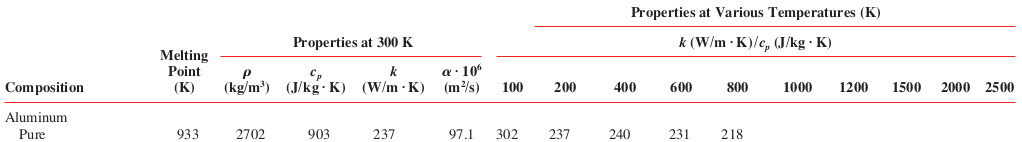
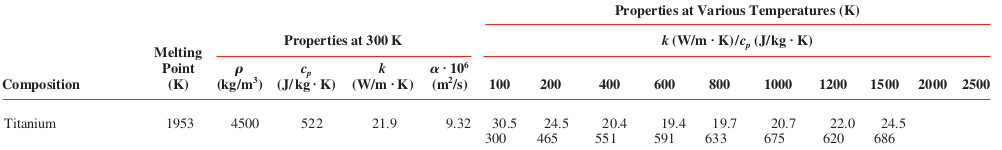

Sehingga didapatkan bahwa difusivitas kalor, $\alpha$, dari material tersebut adalah:
1. Al : $97.1\times 10^-6$
2. Ti : $9.32\times 10^-6$

In [3]:
a = [97.1e-6, 9.32e-6]

## Desain parameter-parameter simulasi
### Tentukan ukuran partisi dari plat
Dicari ukuran partisi yang tepat agar:
1. fitur dari plat dapat terlihat dengan baik
2. tidak ada "abrupt change" dari temperatur sehingga tampilan kurva temperatur dapat dilihat dengan lebih baik 
3. simulasi dapat lebih mendekati plat nyata karena tidak ada informasi yang hilang karena kurangnya node

Diasumsikan bahwa kurva temperatur akan mendekati fungsi sinus. Dicoba plot fungsi sinus dari 0 sampai $\pi$ dan dicari jumlah partisi yang tepat agar fungsi sinus dapat direpresentasikan dengan baik

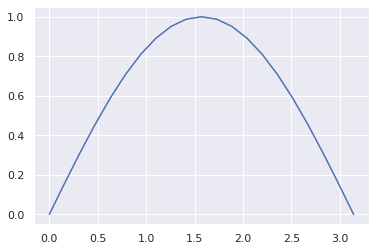

In [4]:
n = 20
x = np.linspace(0,np.pi,n+1)
y = np.sin(x)
plt.plot(x,y)

Ternyata jumlah partisi sebanyak 20, secara subjektif, terlihat dapat merepresentasikan kurva sinus dengan cukup baik. Maka diasumsikan bahwa kurva ini akan merepresentasikan persebaran temperatur dengan baik.

In [5]:
dx = lx/n #m; lx/n

### Tentukan nilai partisi waktu
Dari buku Chapra, partisi waktu akan menentukan stabilitas dari simulasi. Maka, perlu dicari nilai partisi waktu, dt, agar simulasi dapat stabil.
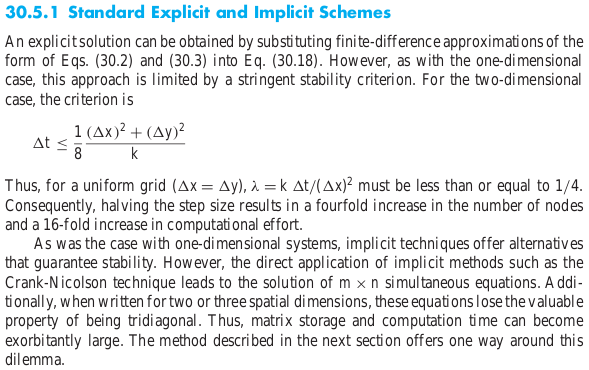

Ternyata, nilai Fo atau λ perlu kurang dari 0.25. Maka nilai dt yang tepat adalah $$dt < \frac{1}{4}\frac{dx^2}{\alpha} = 6.4$$

Maka, pilih dt = 6

In [6]:
dt = 6  #s 

In [7]:
Fo = [a[0]*dt/dx/dx, a[1]*dt/dx/dx]
print(Fo[0], Fo[1])

0.23303999999999997 0.022368


## Pemodelan dan simulasi plat
Terdapat insulator di tengah plat. Menurut buku Incropera:
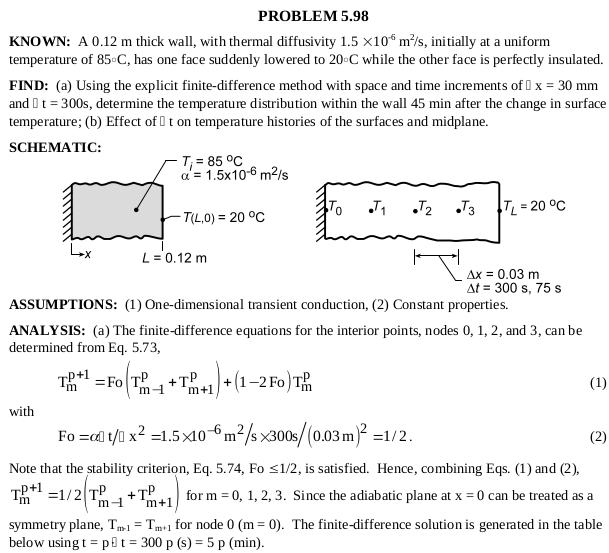


Maka daerah insulasi dapat dianggap sebagai mirror dari kontak konduktor dengan insulator tersebut.

In [8]:
x = np.linspace(0, lx, n+1)
y = np.linspace(0, ly, n+1)

In [9]:
#titik batas, cari indeks yang merepresentasikan titik tepian insulator
xbound1 = (lx-la)/2
xbound2 = xbound1+la
ybound1 = (ly-lb)/2
ybound2 = ybound1+lb
ix1 = np.where(x > xbound1)[0][0]
ix2 = np.where(x < xbound2)[0][-1]
iy1 = np.where(x > ybound1)[0][0]
iy2 = np.where(x < ybound2)[0][-1]
print(ix1, ix2, iy1, iy2)

8 12 8 12


### Kondisi awal
Persiapkan Array sesuai dengan aturan di soal

In [10]:
T0=np.full((1, n+1, n+1),To)
T0[0, 0, :] = Tu
T0[0, -1, :] = Tb
T0[0, :, 0] = Tl
T0[0, :, -1] = Tr
T0

array([[[100.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
          20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
          20.],
        [100.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
          15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
          20.],
        [100.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
          15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
          20.],
        [100.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
          15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
          20.],
        [100.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
          15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
          20.],
        [100.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
          15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
          20.],
        [100.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,
       

### Simulasi untuk Plat Aluminum
Modelkan dan simulasikan Plat Aluminum

In [11]:
material = 0

In [12]:
#Inisiasi T dan Tnew

T = copy.copy(T0)
Tnew = copy.copy(T0)[0]

#Iterasi FDM Eksplisit

#Loop waktu
for t in range(1,int(t_final/dt)+1):
    Tprev = T[t-1] # Inisiasi Tprev sebagai acuan FDM
    
    #Loop x
    for i in range(1, n):
        #Loop y
        for j in range(1, n):
            #Update Temperatur sesuai persamaan FDM di titik-titik luar bahan insulator
            if(not(i>=ix1 and i<=ix2 and j>=iy1 and j<=iy2)):
                Tnew[i, j] = Fo[material]*(Tprev[i][j-1]+Tprev[i][j+1]+Tprev[i-1][j]+Tprev[i+1][j])+(
                    (1-4*Fo[material]))*Tprev[i][j]
    
    #Update daerah tepi insulator agar menjadi cermin bagian dalam plat logam
    Tnew[ix1, iy1+1:iy2] = Tnew[ix1-2, iy1+1:iy2]
    Tnew[ix2, iy1+1:iy2] = Tnew[ix2+2, iy1+1:iy2]
    Tnew[ix1+1:ix2, iy1] = Tnew[ix1+1:ix2, iy1-2]
    Tnew[ix1+1:ix2, iy2] = Tnew[ix1+1:ix2, iy2+2]
    
    #Update bagian ujung-ujung insulator agar merata-ratakan kedua tepi (karena ada ambiguitas 
    #untuk mencerminkan yang mana, maka diasumsikan rata-rata kedua tepi)
    Tnew[ix1, iy1] = (Tnew[ix1+1, iy1] + Tnew[ix1, iy1+1])/2
    Tnew[ix1, iy2] = (Tnew[ix1+1, iy2] + Tnew[ix1, iy2-1])/2
    Tnew[ix2, iy1] = (Tnew[ix2-1, iy1] + Tnew[ix2, iy1+1])/2
    Tnew[ix2, iy2] = (Tnew[ix2-1, iy2] + Tnew[ix2, iy2-1])/2
    
    #Update data T vs waktu dengan data waktu baru
    T = np.vstack((T,Tnew[None]))

#Kembalikan daerah dalam insulasi sebagai T= T awal karena sejatinya insulator tidak berubah temperatur
T[:, ix1:ix2+1, iy1:iy2+1] = To

In [13]:
# Assign data temperatur ke data T_Al = Temperatur alumunium
T_Al = copy.copy(T)

### Simulasi untuk Plat Titanium
Modelkan dan simulasikan plat Titanium

In [14]:
material = 1

In [15]:
T = copy.copy(T0)
Tnew = copy.copy(T0)[0]
for t in range(1,int(t_final/dt)+1):
    Tprev = T[t-1]
    for i in range(1, n):
        for j in range(1, n):
            if(not(i>=ix1 and i<=ix2 and j>=iy1 and j<=iy2)):
                Tnew[i, j] = Fo[material]*(Tprev[i][j-1]+Tprev[i][j+1]+Tprev[i-1][j]+Tprev[i+1][j])+(
                    (1-4*Fo[material]))*Tprev[i][j]
    
    Tnew[ix1, iy1+1:iy2] = Tnew[ix1-2, iy1+1:iy2]
    Tnew[ix2, iy1+1:iy2] = Tnew[ix2+2, iy1+1:iy2]
    Tnew[ix1+1:ix2, iy1] = Tnew[ix1+1:ix2, iy1-2]
    Tnew[ix1+1:ix2, iy2] = Tnew[ix1+1:ix2, iy2+2]
    
    Tnew[ix1, iy1] = (Tnew[ix1+1, iy1] + Tnew[ix1, iy1+1])/2
    Tnew[ix1, iy2] = (Tnew[ix1+1, iy2] + Tnew[ix1, iy2-1])/2
    Tnew[ix2, iy1] = (Tnew[ix2-1, iy1] + Tnew[ix2, iy1+1])/2
    Tnew[ix2, iy2] = (Tnew[ix2-1, iy2] + Tnew[ix2, iy2-1])/2
    
    T = np.vstack((T,Tnew[None]))
T[:, ix1:ix2+1, iy1:iy2+1] = To

In [16]:
T_Ti = copy.copy(T)

## Penyajian hasil
### Plot Temperatur pada 3 waktu berbeda
Di plot 3 grafik untuk masing masing logam pada waktu = (0.333, 0.667, 1)t_final

In [17]:
c = len(T_Al)-1
t = [int(c/3), int(2*c/3), int(c)]

#### t = 0.333 t_final

Text(0.5, 0.98, 'Aluminum t = 996.00s')

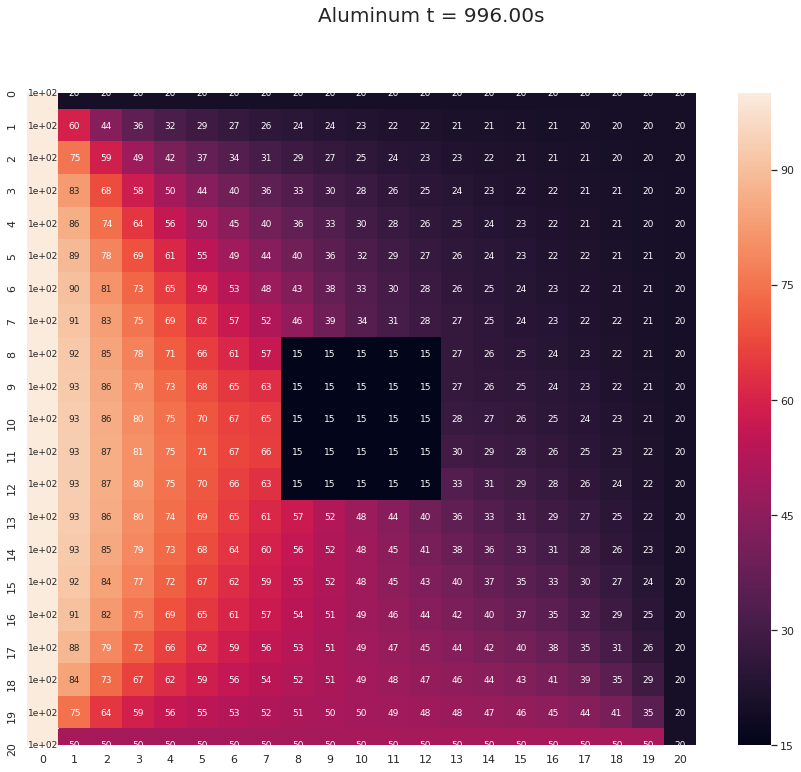

In [18]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[0]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[0]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 996.00s')

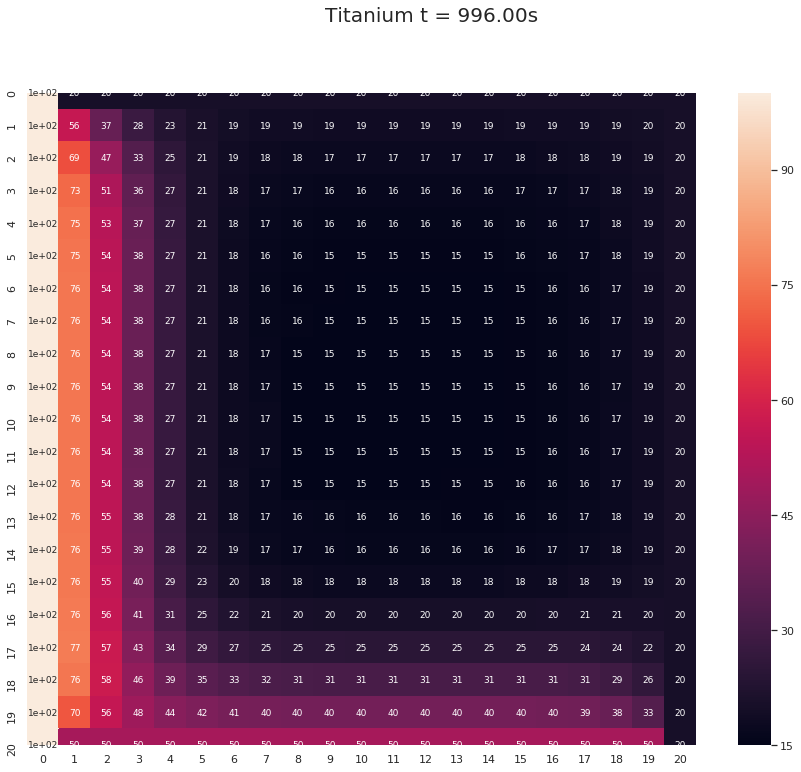

In [19]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[0]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[0]*dt), fontsize=20)

#### t = 0.666 t_final

Text(0.5, 0.98, 'Aluminum t = 1998.00s')

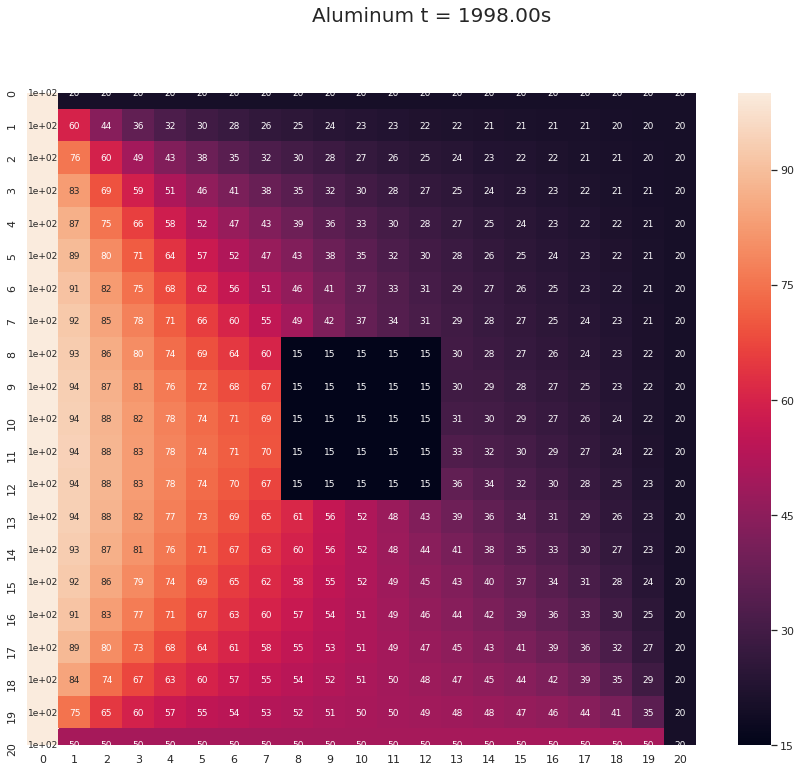

In [20]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[1]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[1]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 1998.00s')

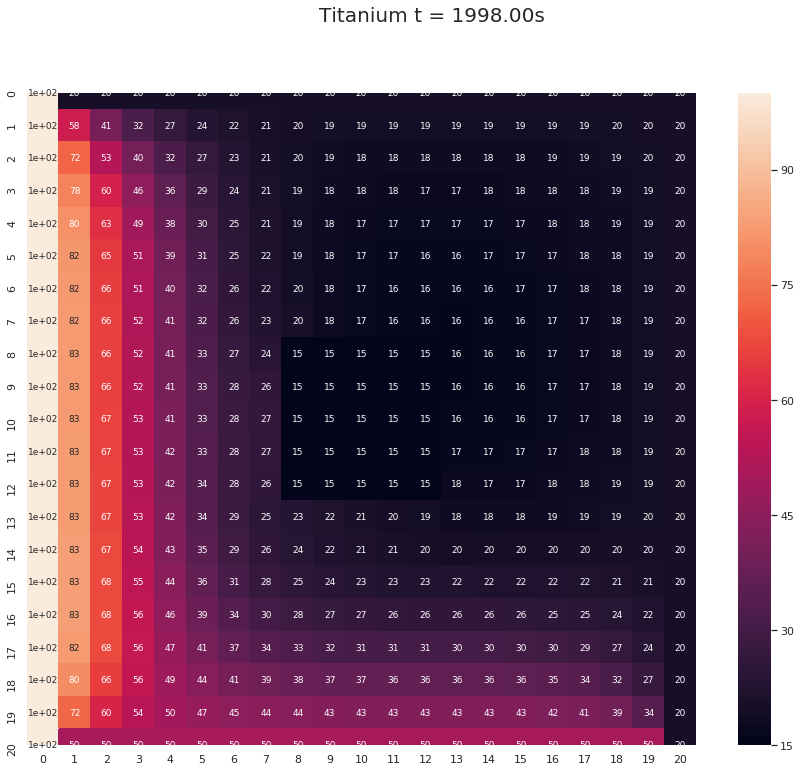

In [21]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[1]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[1]*dt), fontsize=20)

#### t = t_final

Text(0.5, 0.98, 'Aluminum t = 3000.00s')

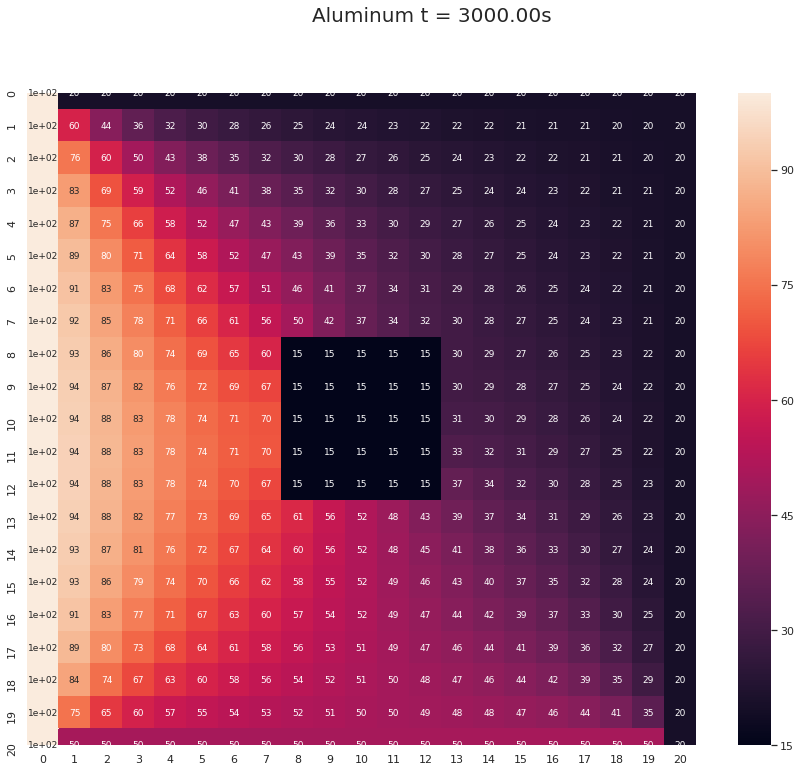

In [22]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[2]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[2]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 3000.00s')

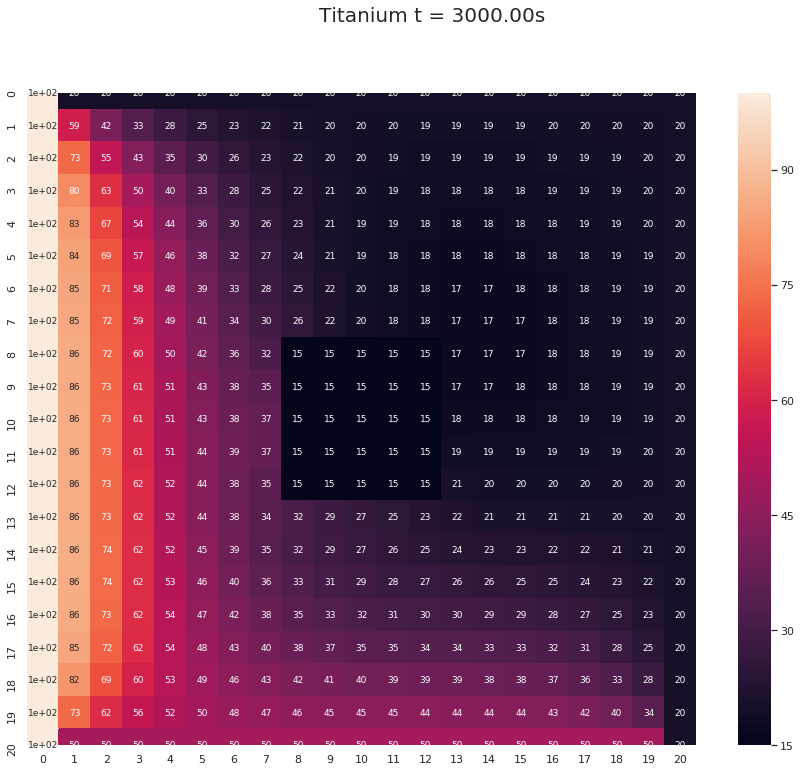

In [23]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[2]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[2]*dt), fontsize=20)

### Animasi temperatur terhadap waktu

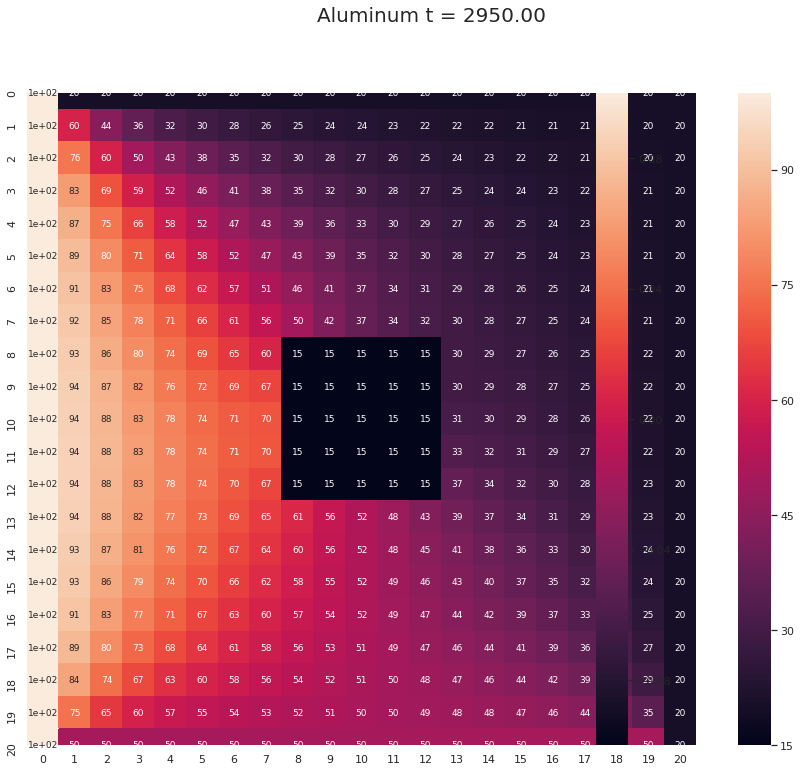

In [24]:
fig, ax = plt.subplots(figsize=(15, 12))
anim = None
nt = int(t_final/t_anim_resolution)
scaling = t_anim_resolution/dt
def init():
    sns.heatmap(np.zeros((n+1, n+1)), ax=ax)

def animate(i):
    fig.clf()
    ax.texts = []
    sns.heatmap(T_Al[int(i*scaling)], annot=True, annot_kws={"size": 9})
    fig.suptitle('Aluminum t = {:0.2f}'.format(i*dt*scaling), fontsize=20)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, repeat=False)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, bitrate=1800)
anim.save('Al.mp4', writer=writer)

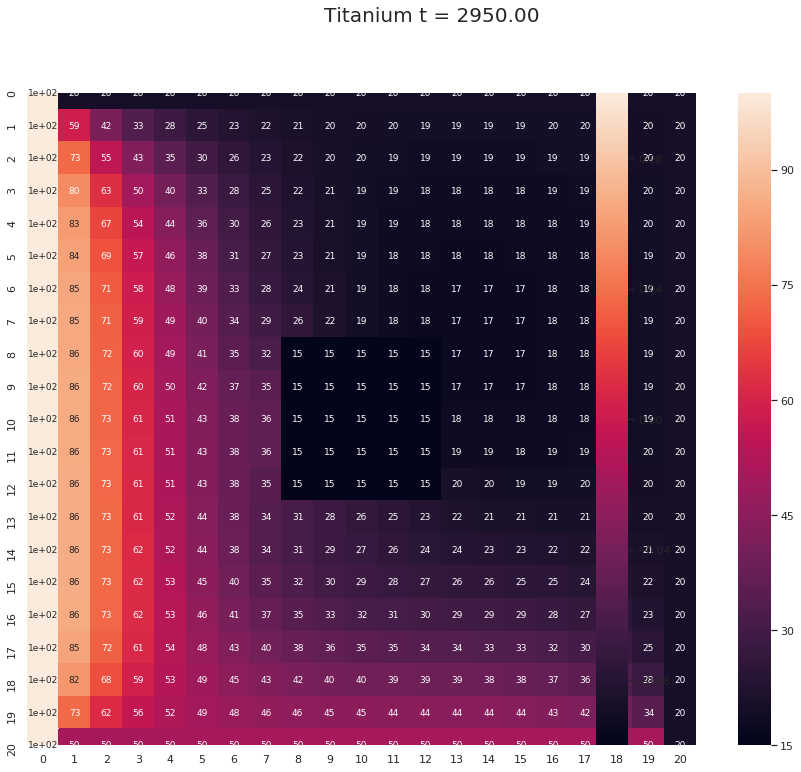

In [25]:
fig, ax = plt.subplots(figsize=(15, 12))
anim = None
nt = int(t_final/t_anim_resolution)
scaling = t_anim_resolution/dt
def init():
    sns.heatmap(np.zeros((n+1, n+1)), ax=ax)

def animate(i):
    fig.clf()
    ax.texts = []
    sns.heatmap(T_Ti[int(i*scaling)], annot=True, annot_kws={"size": 9})
    fig.suptitle('Titanium t = {:0.2f}'.format(i*dt*scaling), fontsize=20)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, repeat=False)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, bitrate=1800)
anim.save('Ti.mp4', writer=writer)

# Seharusnya terdapat file Animasi berjudul "Al.mp4" dan "Ti.mp4" di folder tempat jupyter notebook ini berada.

# Analisis Kestabilan dengan Variasi Partisi Waktu dan Panjang Node
Dari hasil simulasi, terlihat bahwa plat Aluminum mendekati kondisi tunak pada t=3000s karena tidak terjadi perubahan signifikan pada detik tersebut. Hal tersebut menunjukkan bahwa model numerik ini cukup stabil untuk memodelkan sistem yang diberikan di soal. Hal ini dijamin oleh nilai Fo yang kurang dari 0.25, sesuai yang dituliskan oleh Chapra di bukunya.

Akan dilakukan variasi nilai dx dan dt untuk sistem-sistem ini. Akan dikombinasikan dx = 0.025 (n = 40) dan dt = 1

Sehingga terdapat kombinasi sebagai berikut:
1. dx = 0.05, dt = 1 Fo_Al = 0.039
2. dx = 0.025, dt = 6 Fo_Al = 0.932
3. dx = 0.025, dt = 1 Fo_Al = 0.155

## dt = 1; dx = 0.05

In [26]:
dt = 1  #s 
n = 20
dx = dy = lx/n
Fo = [a[0]*dt/dx/dx, a[1]*dt/dx/dx]
print(Fo[0], Fo[1])

0.03884 0.003728


## Pemodelan dan simulasi plat

In [27]:
x = np.linspace(0, lx, n+1)
y = np.linspace(0, ly, n+1)

In [28]:
#titik batas, cari indeks yang merepresentasikan titik tepian insulator
xbound1 = (lx-la)/2
xbound2 = xbound1+la
ybound1 = (ly-lb)/2
ybound2 = ybound1+lb
ix1 = np.where(x > xbound1)[0][0]
ix2 = np.where(x < xbound2)[0][-1]
iy1 = np.where(x > ybound1)[0][0]
iy2 = np.where(x < ybound2)[0][-1]
print(ix1, ix2, iy1, iy2)

8 12 8 12


### Kondisi awal

In [29]:
T0=np.full((1, n+1, n+1),To)
T0[0, 0, :] = Tu
T0[0, -1, :] = Tb
T0[0, :, 0] = Tl
T0[0, :, -1] = Tr

### Simulasi untuk Plat Aluminum dt = 1; dx = 0.05
Modelkan dan simulasikan Plat Aluminum

In [30]:
material = 0

In [31]:
#Inisiasi T dan Tnew

T = copy.copy(T0)
Tnew = copy.copy(T0)[0]

#Iterasi FDM Eksplisit

#Loop waktu
for t in range(1,int(t_final/dt)+1):
    Tprev = T[t-1] # Inisiasi Tprev sebagai acuan FDM
    
    #Loop x
    for i in range(1, n):
        #Loop y
        for j in range(1, n):
            #Update Temperatur sesuai persamaan FDM di titik-titik luar bahan insulator
            if(not(i>=ix1 and i<=ix2 and j>=iy1 and j<=iy2)):
                Tnew[i, j] = Fo[material]*(Tprev[i][j-1]+Tprev[i][j+1]+Tprev[i-1][j]+Tprev[i+1][j])+(
                    (1-4*Fo[material]))*Tprev[i][j]
    
    #Update daerah tepi insulator agar menjadi cermin bagian dalam plat logam
    Tnew[ix1, iy1+1:iy2] = Tnew[ix1-2, iy1+1:iy2]
    Tnew[ix2, iy1+1:iy2] = Tnew[ix2+2, iy1+1:iy2]
    Tnew[ix1+1:ix2, iy1] = Tnew[ix1+1:ix2, iy1-2]
    Tnew[ix1+1:ix2, iy2] = Tnew[ix1+1:ix2, iy2+2]
    
    #Update bagian ujung-ujung insulator agar merata-ratakan kedua tepi (karena ada ambiguitas 
    #untuk mencerminkan yang mana, maka diasumsikan rata-rata kedua tepi)
    Tnew[ix1, iy1] = (Tnew[ix1+1, iy1] + Tnew[ix1, iy1+1])/2
    Tnew[ix1, iy2] = (Tnew[ix1+1, iy2] + Tnew[ix1, iy2-1])/2
    Tnew[ix2, iy1] = (Tnew[ix2-1, iy1] + Tnew[ix2, iy1+1])/2
    Tnew[ix2, iy2] = (Tnew[ix2-1, iy2] + Tnew[ix2, iy2-1])/2
    
    #Update data T vs waktu dengan data waktu baru
    T = np.vstack((T,Tnew[None]))

#Kembalikan daerah dalam insulasi sebagai T= T awal karena sejatinya insulator tidak berubah temperatur
T[:, ix1:ix2+1, iy1:iy2+1] = To

In [32]:
# Assign data temperatur ke data T_Al = Temperatur alumunium
T_Al = copy.copy(T)

### Simulasi untuk Plat Titanium dt = 1; dx = 0.05
Modelkan dan simulasikan plat Titanium

In [33]:
material = 1

In [34]:
T = copy.copy(T0)
Tnew = copy.copy(T0)[0]
for t in range(1,int(t_final/dt)+1):
    Tprev = T[t-1]
    for i in range(1, n):
        for j in range(1, n):
            if(not(i>=ix1 and i<=ix2 and j>=iy1 and j<=iy2)):
                Tnew[i, j] = Fo[material]*(Tprev[i][j-1]+Tprev[i][j+1]+Tprev[i-1][j]+Tprev[i+1][j])+(
                    (1-4*Fo[material]))*Tprev[i][j]
    
    Tnew[ix1, iy1+1:iy2] = Tnew[ix1-2, iy1+1:iy2]
    Tnew[ix2, iy1+1:iy2] = Tnew[ix2+2, iy1+1:iy2]
    Tnew[ix1+1:ix2, iy1] = Tnew[ix1+1:ix2, iy1-2]
    Tnew[ix1+1:ix2, iy2] = Tnew[ix1+1:ix2, iy2+2]
    
    Tnew[ix1, iy1] = (Tnew[ix1+1, iy1] + Tnew[ix1, iy1+1])/2
    Tnew[ix1, iy2] = (Tnew[ix1+1, iy2] + Tnew[ix1, iy2-1])/2
    Tnew[ix2, iy1] = (Tnew[ix2-1, iy1] + Tnew[ix2, iy1+1])/2
    Tnew[ix2, iy2] = (Tnew[ix2-1, iy2] + Tnew[ix2, iy2-1])/2
    
    T = np.vstack((T,Tnew[None]))
T[:, ix1:ix2+1, iy1:iy2+1] = To

In [35]:
T_Ti = copy.copy(T)

## Penyajian hasil dt = 1; dx = 0.05
### Plot Temperatur pada 3 waktu berbeda
Di plot 3 grafik untuk masing masing logam pada waktu = (0.333, 0.667, 1)t_final

In [36]:
c = len(T_Al)-1
t = [int(c/3), int(2*c/3), int(c)]

#### t = 0.333 t_final

Text(0.5, 0.98, 'Aluminum t = 1000.00s')

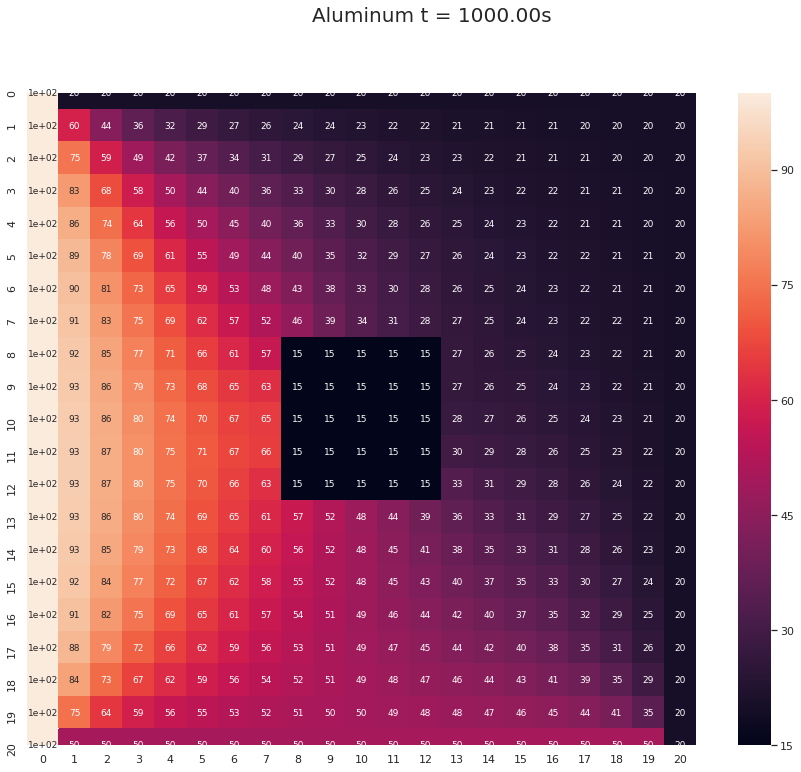

In [37]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[0]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[0]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 1000.00s')

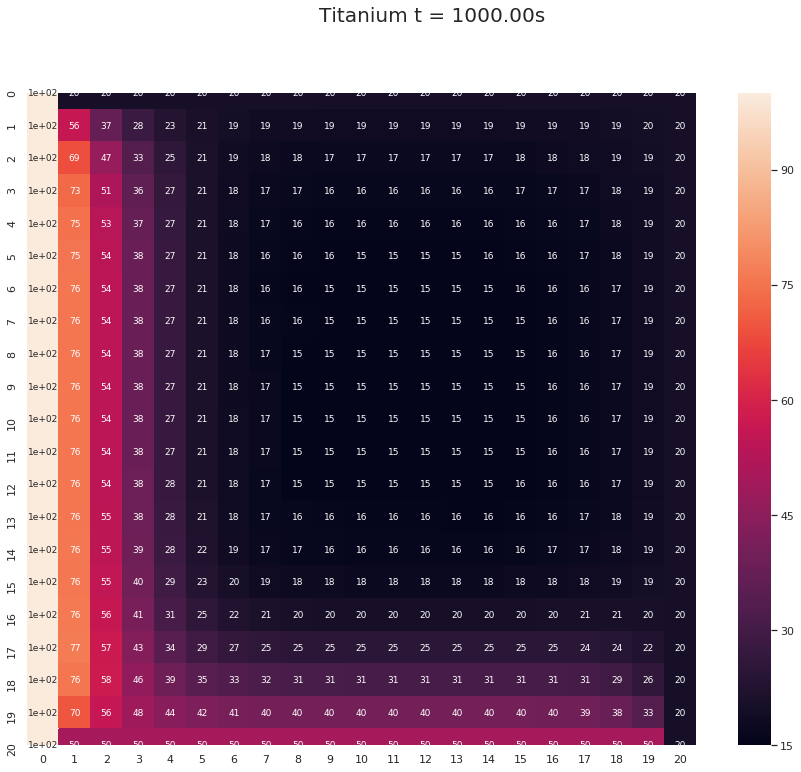

In [38]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[0]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[0]*dt), fontsize=20)

#### t = 0.666 t_final

Text(0.5, 0.98, 'Aluminum t = 2000.00s')

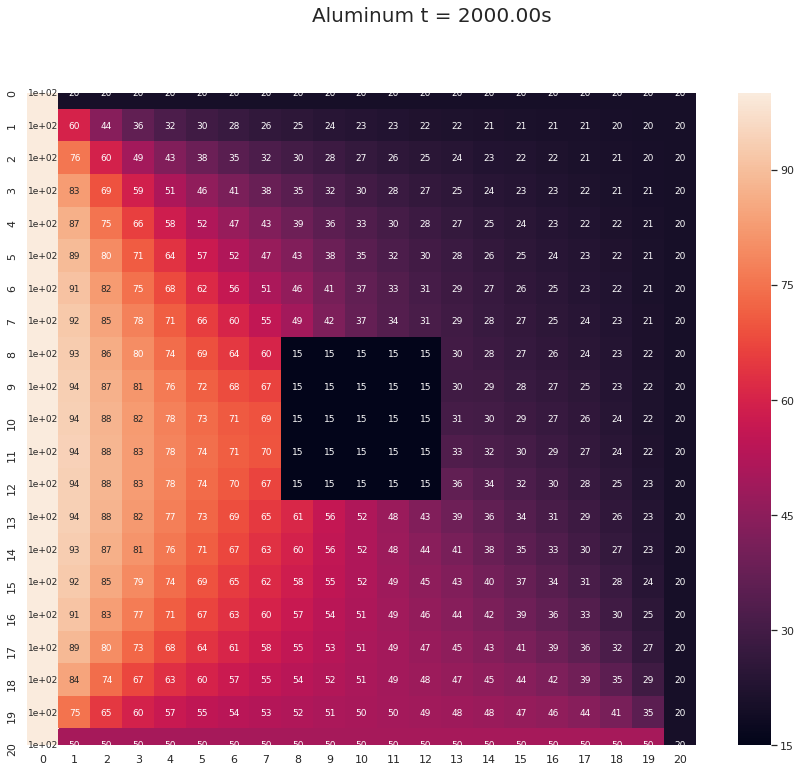

In [39]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[1]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[1]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 2000.00s')

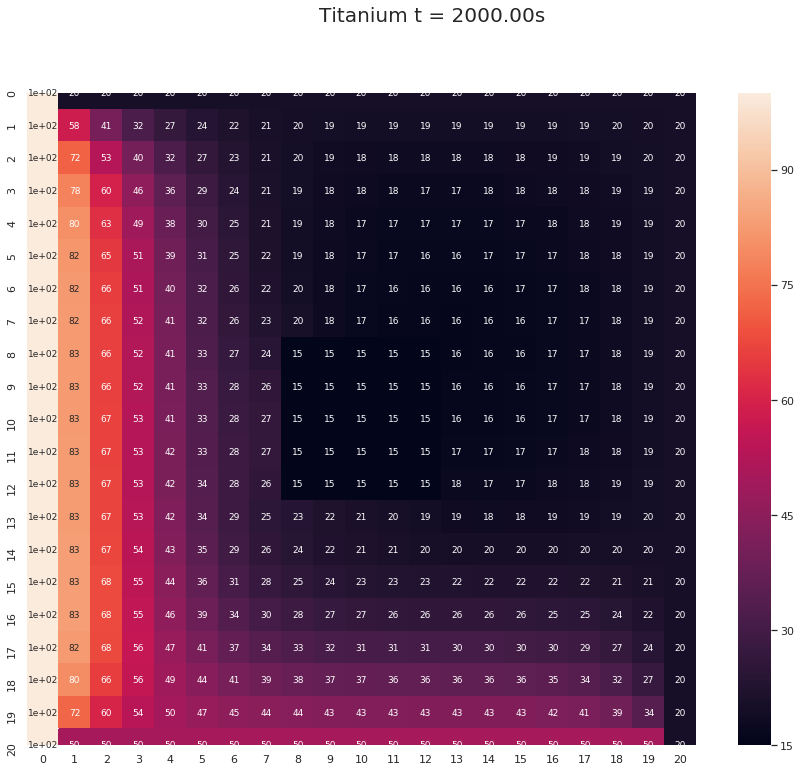

In [40]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[1]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[1]*dt), fontsize=20)

#### t = t_final

Text(0.5, 0.98, 'Aluminum t = 3000.00s')

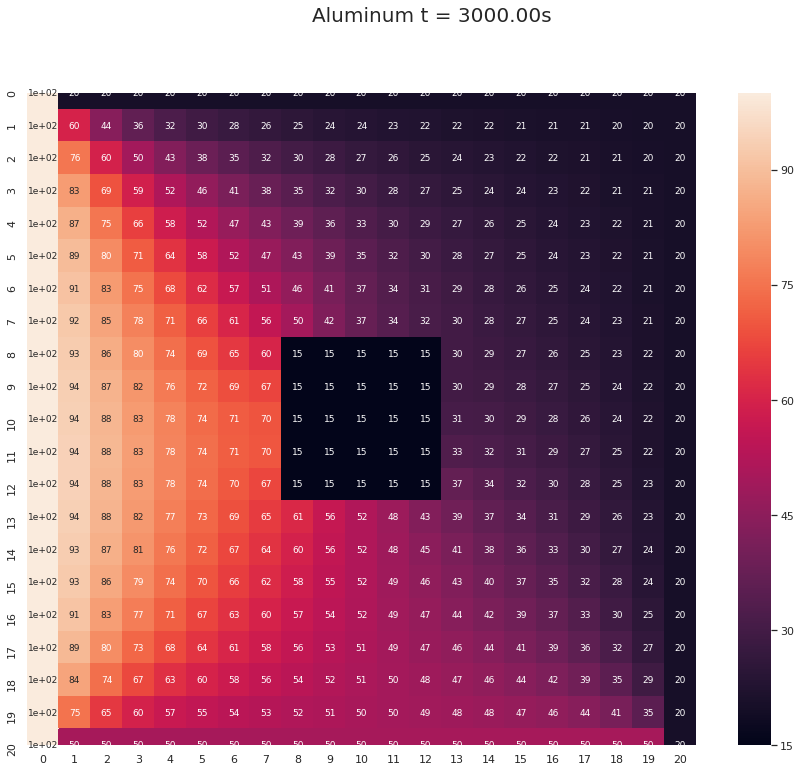

In [41]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[2]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[2]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 3000.00s')

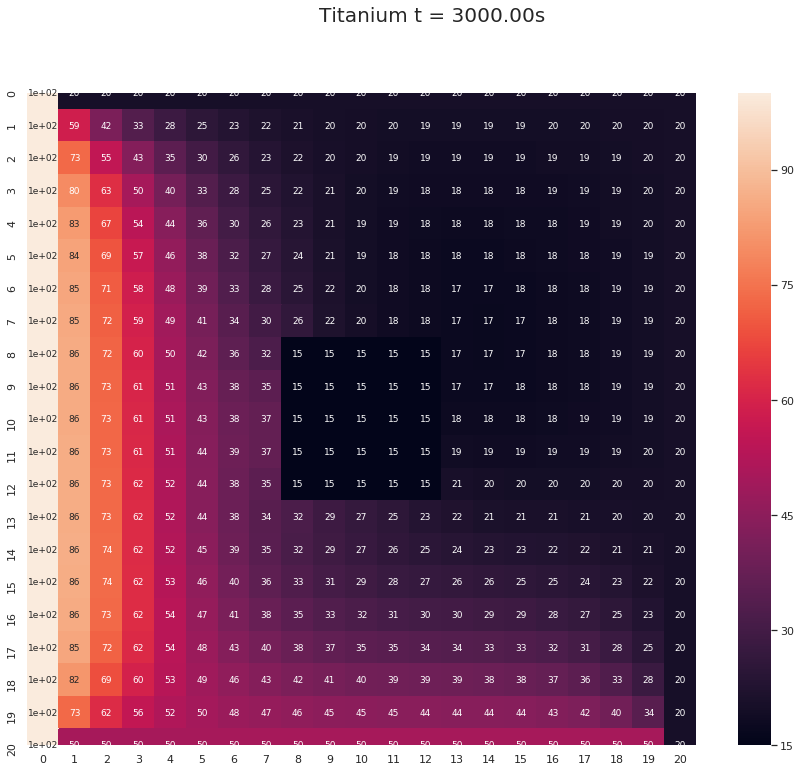

In [42]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[2]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[2]*dt), fontsize=20)

## dt = 6; dx = 0.025

In [43]:
dt = 6  #s 
n = 40
dx = dy = lx/n
Fo = [a[0]*dt/dx/dx, a[1]*dt/dx/dx]
print(Fo[0], Fo[1])

0.9321599999999999 0.089472


## Pemodelan dan simulasi plat

In [44]:
x = np.linspace(0, lx, n+1)
y = np.linspace(0, ly, n+1)

In [45]:
#titik batas, cari indeks yang merepresentasikan titik tepian insulator
xbound1 = (lx-la)/2
xbound2 = xbound1+la
ybound1 = (ly-lb)/2
ybound2 = ybound1+lb
ix1 = np.where(x > xbound1)[0][0]
ix2 = np.where(x < xbound2)[0][-1]
iy1 = np.where(x > ybound1)[0][0]
iy2 = np.where(x < ybound2)[0][-1]
print(ix1, ix2, iy1, iy2)

16 24 16 24


### Kondisi awal

In [46]:
T0=np.full((1, n+1, n+1),To)
T0[0, 0, :] = Tu
T0[0, -1, :] = Tb
T0[0, :, 0] = Tl
T0[0, :, -1] = Tr

### Simulasi untuk Plat Aluminum dt = 6; dx = 0.025
Modelkan dan simulasikan Plat Aluminum

In [47]:
material = 0

In [48]:
#Inisiasi T dan Tnew

T = copy.copy(T0)
Tnew = copy.copy(T0)[0]

#Iterasi FDM Eksplisit

#Loop waktu
for t in range(1,int(t_final/dt)+1):
    Tprev = T[t-1] # Inisiasi Tprev sebagai acuan FDM
    
    #Loop x
    for i in range(1, n):
        #Loop y
        for j in range(1, n):
            #Update Temperatur sesuai persamaan FDM di titik-titik luar bahan insulator
            if(not(i>=ix1 and i<=ix2 and j>=iy1 and j<=iy2)):
                Tnew[i, j] = Fo[material]*(Tprev[i][j-1]+Tprev[i][j+1]+Tprev[i-1][j]+Tprev[i+1][j])+(
                    (1-4*Fo[material]))*Tprev[i][j]
    
    #Update daerah tepi insulator agar menjadi cermin bagian dalam plat logam
    Tnew[ix1, iy1+1:iy2] = Tnew[ix1-2, iy1+1:iy2]
    Tnew[ix2, iy1+1:iy2] = Tnew[ix2+2, iy1+1:iy2]
    Tnew[ix1+1:ix2, iy1] = Tnew[ix1+1:ix2, iy1-2]
    Tnew[ix1+1:ix2, iy2] = Tnew[ix1+1:ix2, iy2+2]
    
    #Update bagian ujung-ujung insulator agar merata-ratakan kedua tepi (karena ada ambiguitas 
    #untuk mencerminkan yang mana, maka diasumsikan rata-rata kedua tepi)
    Tnew[ix1, iy1] = (Tnew[ix1+1, iy1] + Tnew[ix1, iy1+1])/2
    Tnew[ix1, iy2] = (Tnew[ix1+1, iy2] + Tnew[ix1, iy2-1])/2
    Tnew[ix2, iy1] = (Tnew[ix2-1, iy1] + Tnew[ix2, iy1+1])/2
    Tnew[ix2, iy2] = (Tnew[ix2-1, iy2] + Tnew[ix2, iy2-1])/2
    
    #Update data T vs waktu dengan data waktu baru
    T = np.vstack((T,Tnew[None]))

#Kembalikan daerah dalam insulasi sebagai T= T awal karena sejatinya insulator tidak berubah temperatur
T[:, ix1:ix2+1, iy1:iy2+1] = To

/home/vieri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/home/vieri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/home/vieri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
/home/vieri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/vieri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [49]:
# Assign data temperatur ke data T_Al = Temperatur alumunium
T_Al = copy.copy(T)

### Simulasi untuk Plat Titanium dt = 6; dx = 0.025
Modelkan dan simulasikan plat Titanium

In [50]:
material = 1

In [51]:
T = copy.copy(T0)
Tnew = copy.copy(T0)[0]
for t in range(1,int(t_final/dt)+1):
    Tprev = T[t-1]
    for i in range(1, n):
        for j in range(1, n):
            if(not(i>=ix1 and i<=ix2 and j>=iy1 and j<=iy2)):
                Tnew[i, j] = Fo[material]*(Tprev[i][j-1]+Tprev[i][j+1]+Tprev[i-1][j]+Tprev[i+1][j])+(
                    (1-4*Fo[material]))*Tprev[i][j]
    
    Tnew[ix1, iy1+1:iy2] = Tnew[ix1-2, iy1+1:iy2]
    Tnew[ix2, iy1+1:iy2] = Tnew[ix2+2, iy1+1:iy2]
    Tnew[ix1+1:ix2, iy1] = Tnew[ix1+1:ix2, iy1-2]
    Tnew[ix1+1:ix2, iy2] = Tnew[ix1+1:ix2, iy2+2]
    
    Tnew[ix1, iy1] = (Tnew[ix1+1, iy1] + Tnew[ix1, iy1+1])/2
    Tnew[ix1, iy2] = (Tnew[ix1+1, iy2] + Tnew[ix1, iy2-1])/2
    Tnew[ix2, iy1] = (Tnew[ix2-1, iy1] + Tnew[ix2, iy1+1])/2
    Tnew[ix2, iy2] = (Tnew[ix2-1, iy2] + Tnew[ix2, iy2-1])/2
    
    T = np.vstack((T,Tnew[None]))
T[:, ix1:ix2+1, iy1:iy2+1] = To

In [52]:
T_Ti = copy.copy(T)

## Penyajian hasil dt = 6; dx = 0.025
### Plot Temperatur pada 3 waktu berbeda
Di plot 3 grafik untuk masing masing logam pada waktu = (0.333, 0.667, 1)t_final

In [53]:
c = len(T_Al)-1
t = [int(c/3), int(2*c/3), int(c)]

#### t = 0.333 t_final

Text(0.5, 0.98, 'Aluminum t = 996.00s')

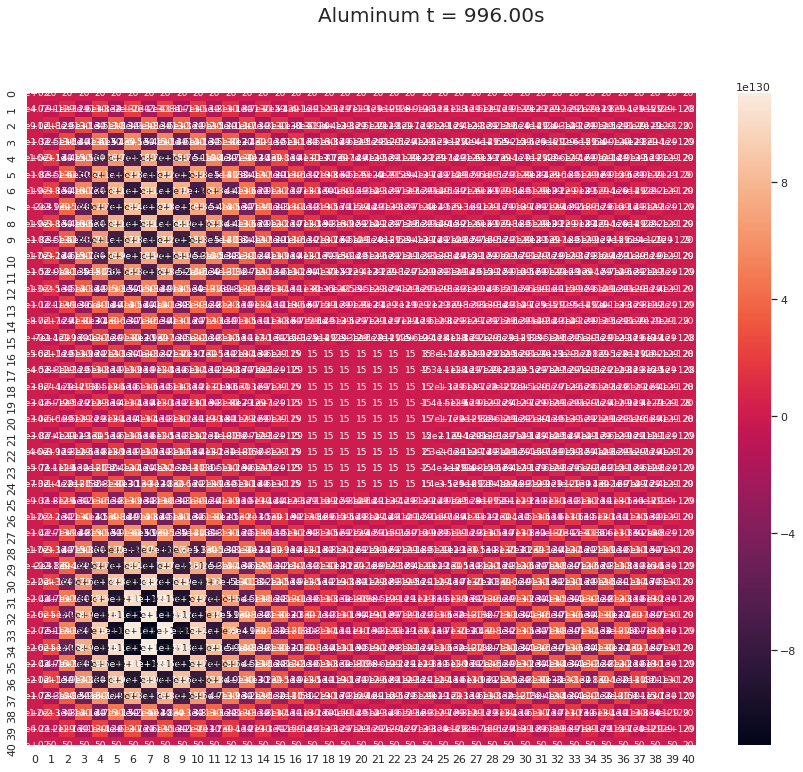

In [54]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[0]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[0]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 996.00s')

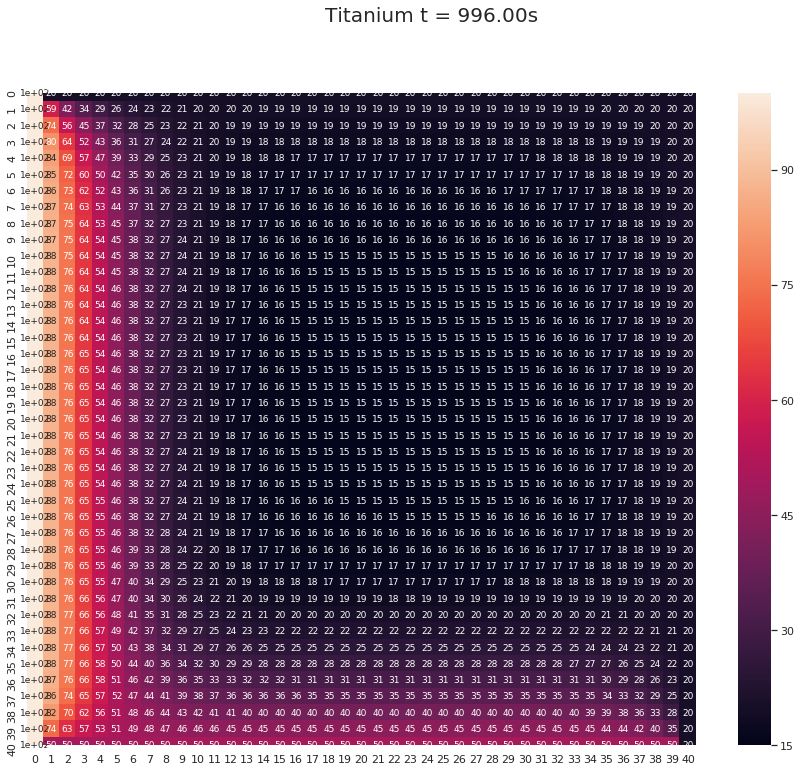

In [55]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[0]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[0]*dt), fontsize=20)

#### t = 0.666 t_final

Text(0.5, 0.98, 'Aluminum t = 1998.00s')

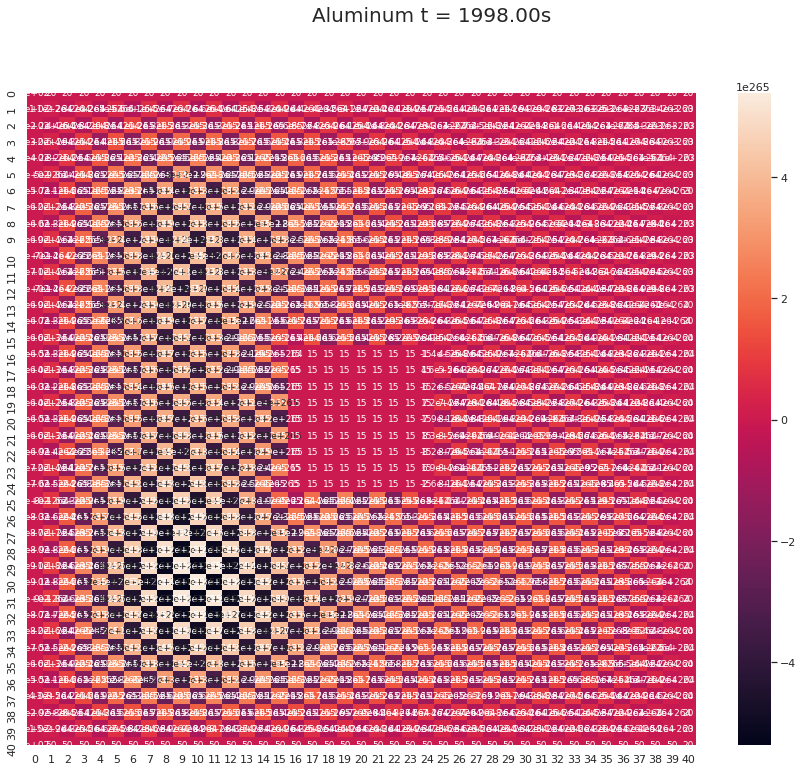

In [56]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[1]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[1]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 1998.00s')

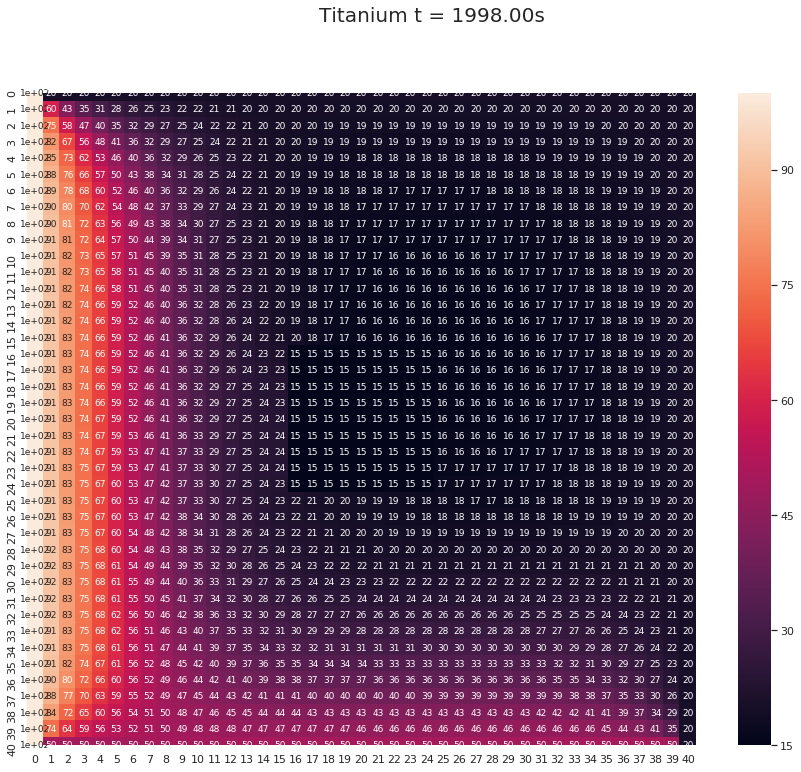

In [57]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[1]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[1]*dt), fontsize=20)

#### t = t_final

Text(0.5, 0.98, 'Aluminum t = 3000.00s')

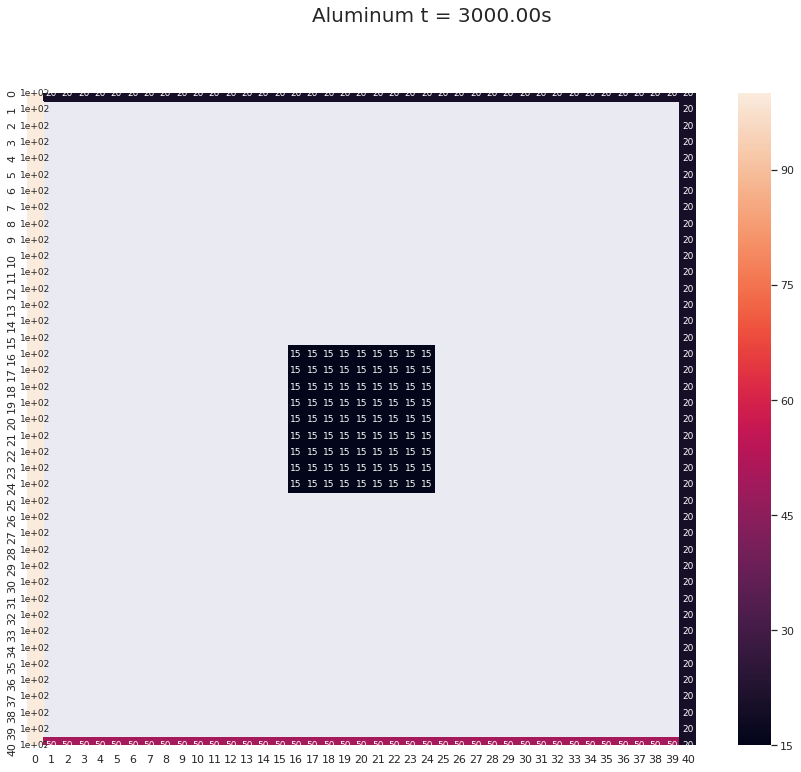

In [58]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[2]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[2]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 3000.00s')

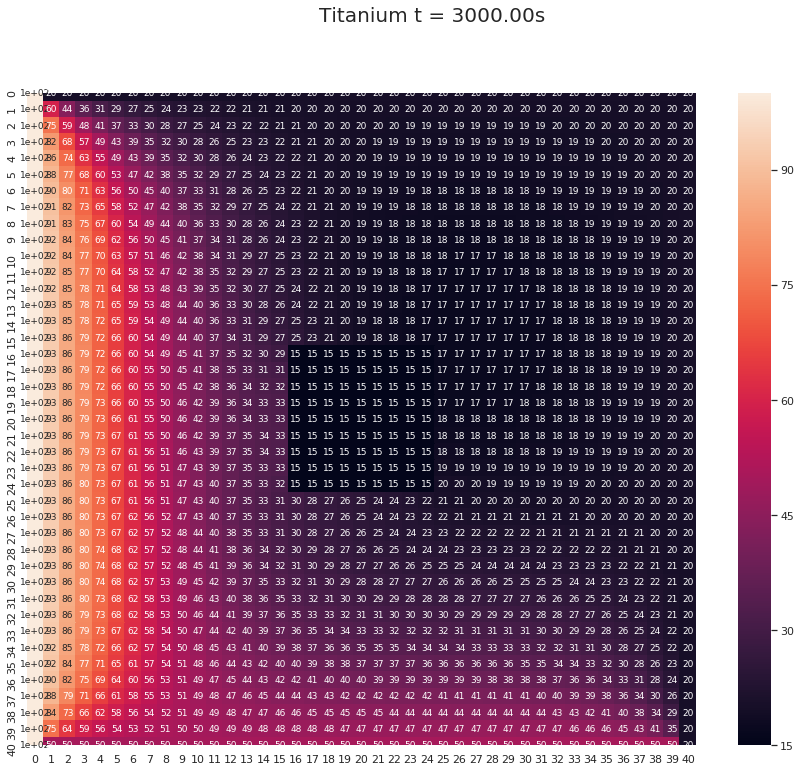

In [59]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[2]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[2]*dt), fontsize=20)

## dt = 1; dx = 0.025

In [60]:
dt = 1  #s 
n = 40
dx = dy = lx/n
Fo = [a[0]*dt/dx/dx, a[1]*dt/dx/dx]
print(Fo[0], Fo[1])

0.15536 0.014912


## Pemodelan dan simulasi plat

In [61]:
x = np.linspace(0, lx, n+1)
y = np.linspace(0, ly, n+1)

In [62]:
#titik batas, cari indeks yang merepresentasikan titik tepian insulator
xbound1 = (lx-la)/2
xbound2 = xbound1+la
ybound1 = (ly-lb)/2
ybound2 = ybound1+lb
ix1 = np.where(x > xbound1)[0][0]
ix2 = np.where(x < xbound2)[0][-1]
iy1 = np.where(x > ybound1)[0][0]
iy2 = np.where(x < ybound2)[0][-1]
print(ix1, ix2, iy1, iy2)

16 24 16 24


### Kondisi awal

In [63]:
T0=np.full((1, n+1, n+1),To)
T0[0, 0, :] = Tu
T0[0, -1, :] = Tb
T0[0, :, 0] = Tl
T0[0, :, -1] = Tr

### Simulasi untuk Plat Aluminum dt = 1; dx = 0.025
Modelkan dan simulasikan Plat Aluminum

In [64]:
material = 0

In [65]:
#Inisiasi T dan Tnew

T = copy.copy(T0)
Tnew = copy.copy(T0)[0]

#Iterasi FDM Eksplisit

#Loop waktu
for t in range(1,int(t_final/dt)+1):
    Tprev = T[t-1] # Inisiasi Tprev sebagai acuan FDM
    
    #Loop x
    for i in range(1, n):
        #Loop y
        for j in range(1, n):
            #Update Temperatur sesuai persamaan FDM di titik-titik luar bahan insulator
            if(not(i>=ix1 and i<=ix2 and j>=iy1 and j<=iy2)):
                Tnew[i, j] = Fo[material]*(Tprev[i][j-1]+Tprev[i][j+1]+Tprev[i-1][j]+Tprev[i+1][j])+(
                    (1-4*Fo[material]))*Tprev[i][j]
    
    #Update daerah tepi insulator agar menjadi cermin bagian dalam plat logam
    Tnew[ix1, iy1+1:iy2] = Tnew[ix1-2, iy1+1:iy2]
    Tnew[ix2, iy1+1:iy2] = Tnew[ix2+2, iy1+1:iy2]
    Tnew[ix1+1:ix2, iy1] = Tnew[ix1+1:ix2, iy1-2]
    Tnew[ix1+1:ix2, iy2] = Tnew[ix1+1:ix2, iy2+2]
    
    #Update bagian ujung-ujung insulator agar merata-ratakan kedua tepi (karena ada ambiguitas 
    #untuk mencerminkan yang mana, maka diasumsikan rata-rata kedua tepi)
    Tnew[ix1, iy1] = (Tnew[ix1+1, iy1] + Tnew[ix1, iy1+1])/2
    Tnew[ix1, iy2] = (Tnew[ix1+1, iy2] + Tnew[ix1, iy2-1])/2
    Tnew[ix2, iy1] = (Tnew[ix2-1, iy1] + Tnew[ix2, iy1+1])/2
    Tnew[ix2, iy2] = (Tnew[ix2-1, iy2] + Tnew[ix2, iy2-1])/2
    
    #Update data T vs waktu dengan data waktu baru
    T = np.vstack((T,Tnew[None]))

#Kembalikan daerah dalam insulasi sebagai T= T awal karena sejatinya insulator tidak berubah temperatur
T[:, ix1:ix2+1, iy1:iy2+1] = To

In [66]:
# Assign data temperatur ke data T_Al = Temperatur alumunium
T_Al = copy.copy(T)

### Simulasi untuk Plat Titanium dt = 1; dx = 0.025
Modelkan dan simulasikan plat Titanium

In [67]:
material = 1

In [68]:
T = copy.copy(T0)
Tnew = copy.copy(T0)[0]
for t in range(1,int(t_final/dt)+1):
    Tprev = T[t-1]
    for i in range(1, n):
        for j in range(1, n):
            if(not(i>=ix1 and i<=ix2 and j>=iy1 and j<=iy2)):
                Tnew[i, j] = Fo[material]*(Tprev[i][j-1]+Tprev[i][j+1]+Tprev[i-1][j]+Tprev[i+1][j])+(
                    (1-4*Fo[material]))*Tprev[i][j]
    
    Tnew[ix1, iy1+1:iy2] = Tnew[ix1-2, iy1+1:iy2]
    Tnew[ix2, iy1+1:iy2] = Tnew[ix2+2, iy1+1:iy2]
    Tnew[ix1+1:ix2, iy1] = Tnew[ix1+1:ix2, iy1-2]
    Tnew[ix1+1:ix2, iy2] = Tnew[ix1+1:ix2, iy2+2]
    
    Tnew[ix1, iy1] = (Tnew[ix1+1, iy1] + Tnew[ix1, iy1+1])/2
    Tnew[ix1, iy2] = (Tnew[ix1+1, iy2] + Tnew[ix1, iy2-1])/2
    Tnew[ix2, iy1] = (Tnew[ix2-1, iy1] + Tnew[ix2, iy1+1])/2
    Tnew[ix2, iy2] = (Tnew[ix2-1, iy2] + Tnew[ix2, iy2-1])/2
    
    T = np.vstack((T,Tnew[None]))
T[:, ix1:ix2+1, iy1:iy2+1] = To

In [69]:
T_Ti = copy.copy(T)

## Penyajian hasil dt = 1; dx = 0.025
### Plot Temperatur pada 3 waktu berbeda
Di plot 3 grafik untuk masing masing logam pada waktu = (0.333, 0.667, 1)t_final

In [70]:
c = len(T_Al)-1
t = [int(c/3), int(2*c/3), int(c)]

#### t = 0.333 t_final

Text(0.5, 0.98, 'Aluminum t = 1000.00s')

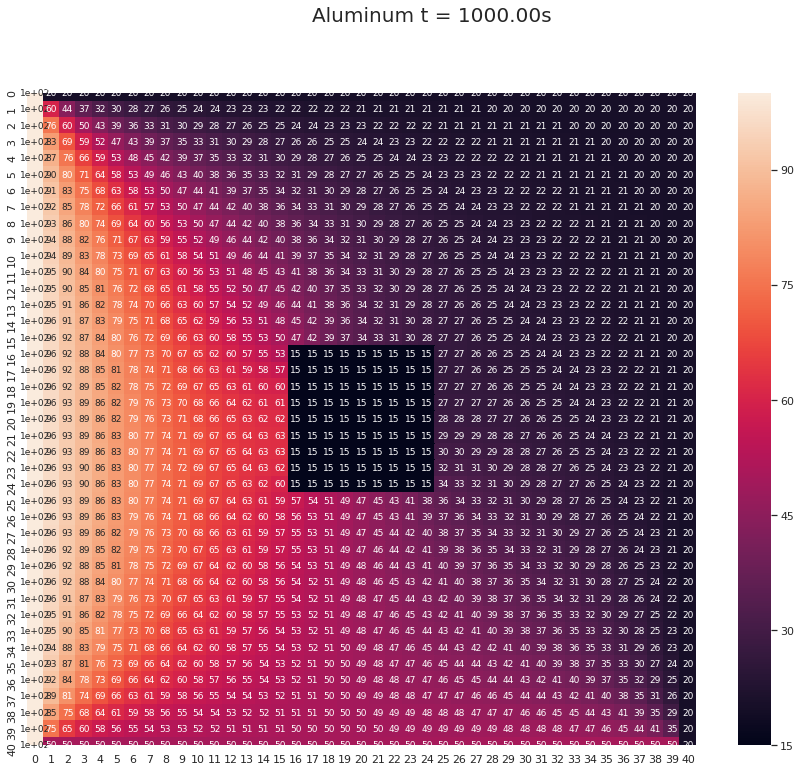

In [71]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[0]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[0]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 1000.00s')

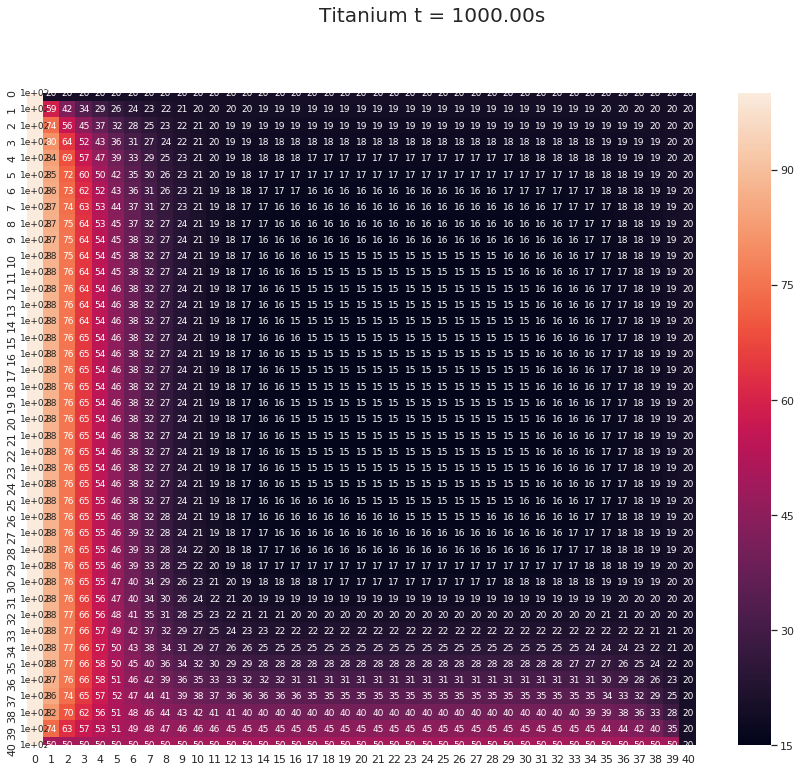

In [72]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[0]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[0]*dt), fontsize=20)

#### t = 0.666 t_final

Text(0.5, 0.98, 'Aluminum t = 2000.00s')

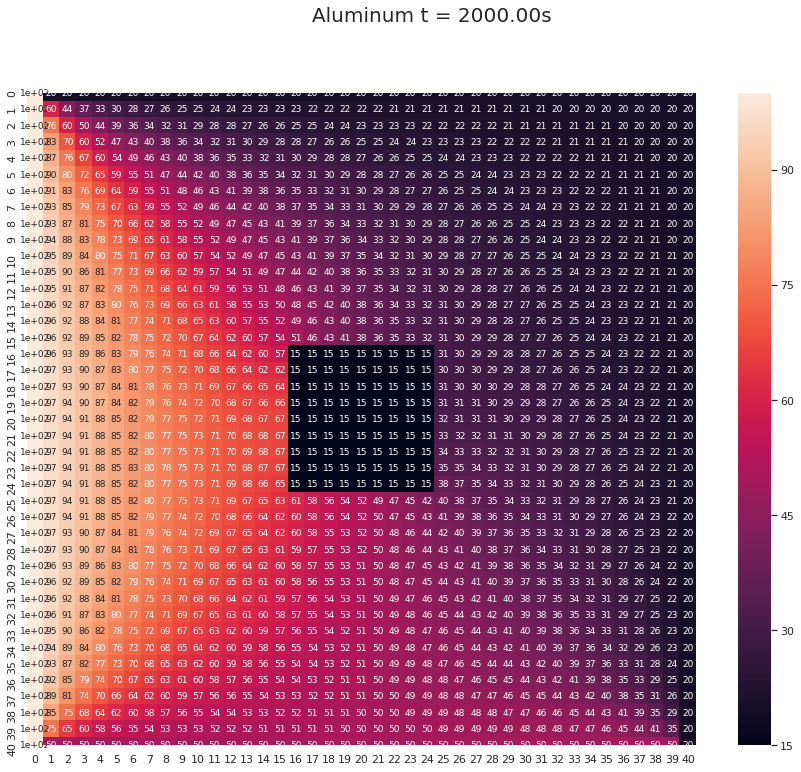

In [73]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[1]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[1]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 2000.00s')

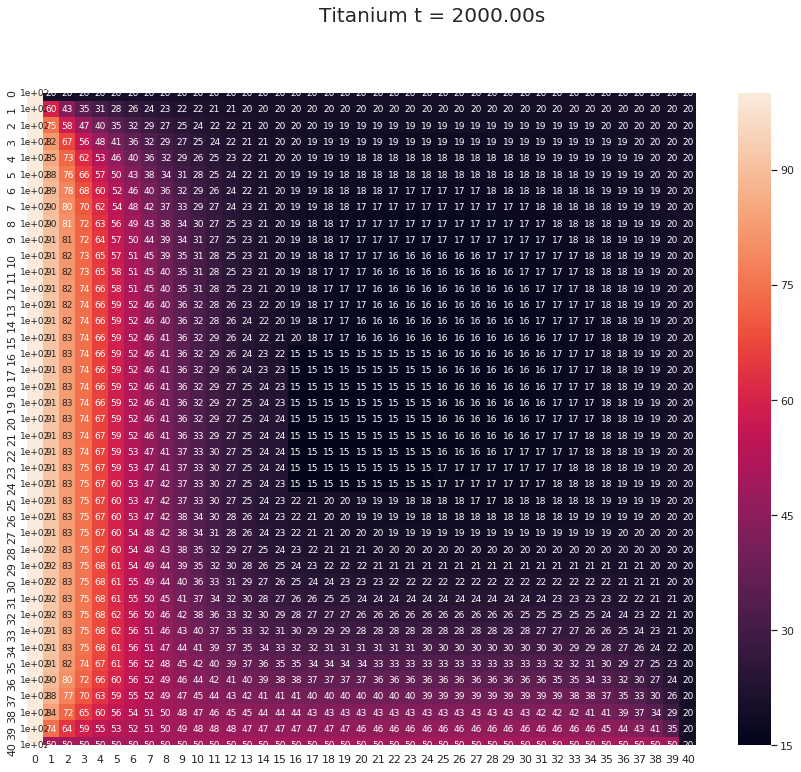

In [74]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[1]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[1]*dt), fontsize=20)

#### t = t_final

Text(0.5, 0.98, 'Aluminum t = 3000.00s')

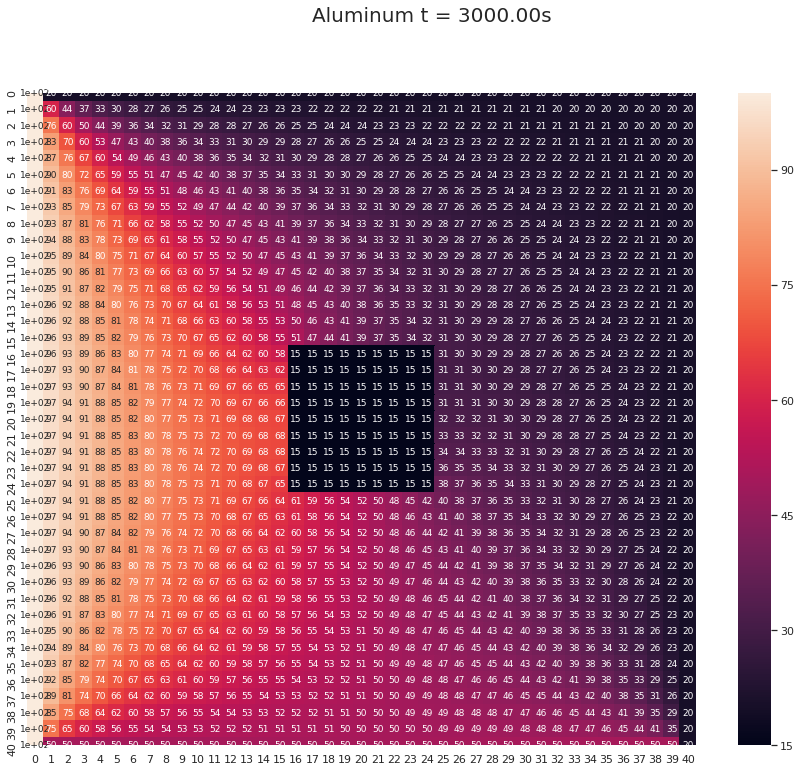

In [75]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Al[t[2]], annot=True, annot_kws={"size": 9})
fig.suptitle('Aluminum t = {:0.2f}s'.format(t[2]*dt), fontsize=20)

Text(0.5, 0.98, 'Titanium t = 3000.00s')

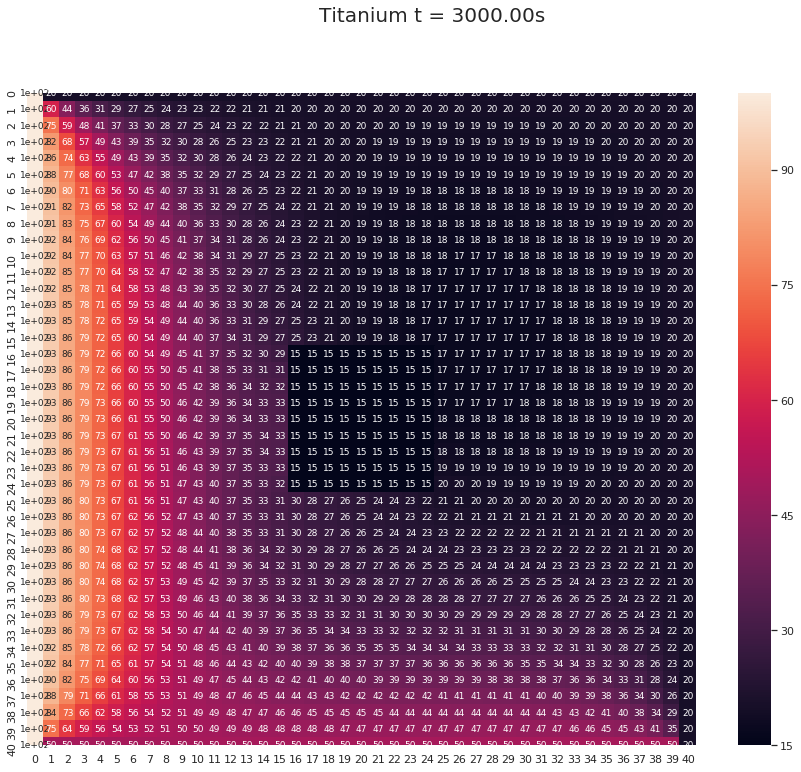

In [76]:
fig, ax = plt.subplots(figsize=(15, 12))
fig.clf()
sns.heatmap(T_Ti[t[2]], annot=True, annot_kws={"size": 9})
fig.suptitle('Titanium t = {:0.2f}s'.format(t[2]*dt), fontsize=20)

# Analisis
Pemadatan grid menjadi 40 titik node membuat ketidak stabilan apabila partisi waktu tetap dalam 6 detik. Terlihat bahwa FDM divergen hingga mengalami overflow.

Pengurangan partisi waktu menjadi 1 detik mengakibatkan sistem numerik menjadi konvergen kembali sehingga dapat dicapai kondisi tunak pada sistem yang disimulasikan.

Sementara itu, penambahan partisi waktu tanpa memadatkan node terlihat tidak mengubah apa-apa. Namun dapat diduga bahwa pemendekan partisi waktu dapat mengurangi error dalam simulasi akibat truncation error dari pendekatan Finite Difference yang digunakan.

# Sekian dan terima kasih